# Exploratory Data Analysis for IMDB 50K Movie Reviews

- In this notebook, we perform initial exploration and cleaning of the IMDB movie reviews dataset.
- This dataset will later be used to fine-tune a RoBERTa model for binary sentiment classification (positive or negative).

### Import Libraries for Data Analysis and Text Preprocessing

We import libraries needed for:

- File operations and data handling (`os`, `pandas`, `numpy`)
- Data visualization (`seaborn`, `plotly.express`, `matplotlib`, `WordCloud`)
- Text preprocessing (`string`, `re`, `stopwords`)
- Feature extraction (`CountVectorizer`)

In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import string, re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Load the IMDB Movie Reviews Dataset

We load the dataset from the specified CSV file. It contains 50,000 movie reviews along with their corresponding sentiment labels (`positive` or `negative`).

In [3]:
data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


### Check for Duplicate Reviews

Using `describe()`, we observe that there are 418 non-unique reviews in the dataset. These duplicates will need to be removed during preprocessing.


In [4]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [5]:
data = data.drop_duplicates()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


### Sentiment Distribution

The dataset is perfectly balanced with ~25,000 positive and ~25,000 negative reviews.


<Axes: xlabel='sentiment', ylabel='count'>

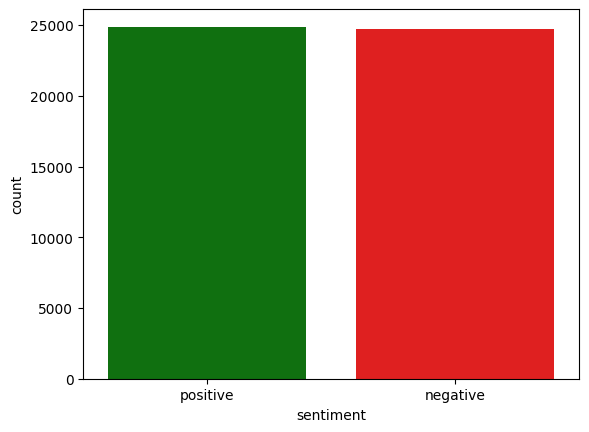

In [7]:
sns.countplot(x="sentiment", data=data, palette={"positive":"green", "negative":"red"})

### Note on Stopword Removal

Although stopwords and punctuation are typically removed during preprocessing, I **choose not to remove them** in this case.  

> **Note:** Since I will be fine-tuning a pre-trained **RoBERTa** model—which was trained on raw text that includes stopwords and punctuation removing them might negatively impact model performance. Therefore, I keep the text as natural and close to its original form as possible.

*You can remove stopwords by uncommenting the lines below.*

In [8]:
#stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
#stop.update(punctuation)

### Text Cleaning

In this step, I define a set of functions to clean the raw review text. My goal is to remove unnecessary elements that could introduce noise into the model.

In [9]:
# Remove HTML tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Remove content inside square brackets
def remove_between_square_brackets(text):
    return re.sub('[]]∗[^]]*', '', text)
    
# Remove URLs
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
    
# Remove stopwords and non-alphabetic tokens
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    #text = remove_stopwords(text) # Uncomment to remove stopwords
    return text

data['review'] = data['review'].apply(denoise_text)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Encode Sentiment Labels (Label Encoding)

In [10]:
data.sentiment.replace("positive" , 1 , inplace = True)
data.sentiment.replace("negative" , 0 , inplace = True)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### Visualize Most Common Words in Positive Reviews

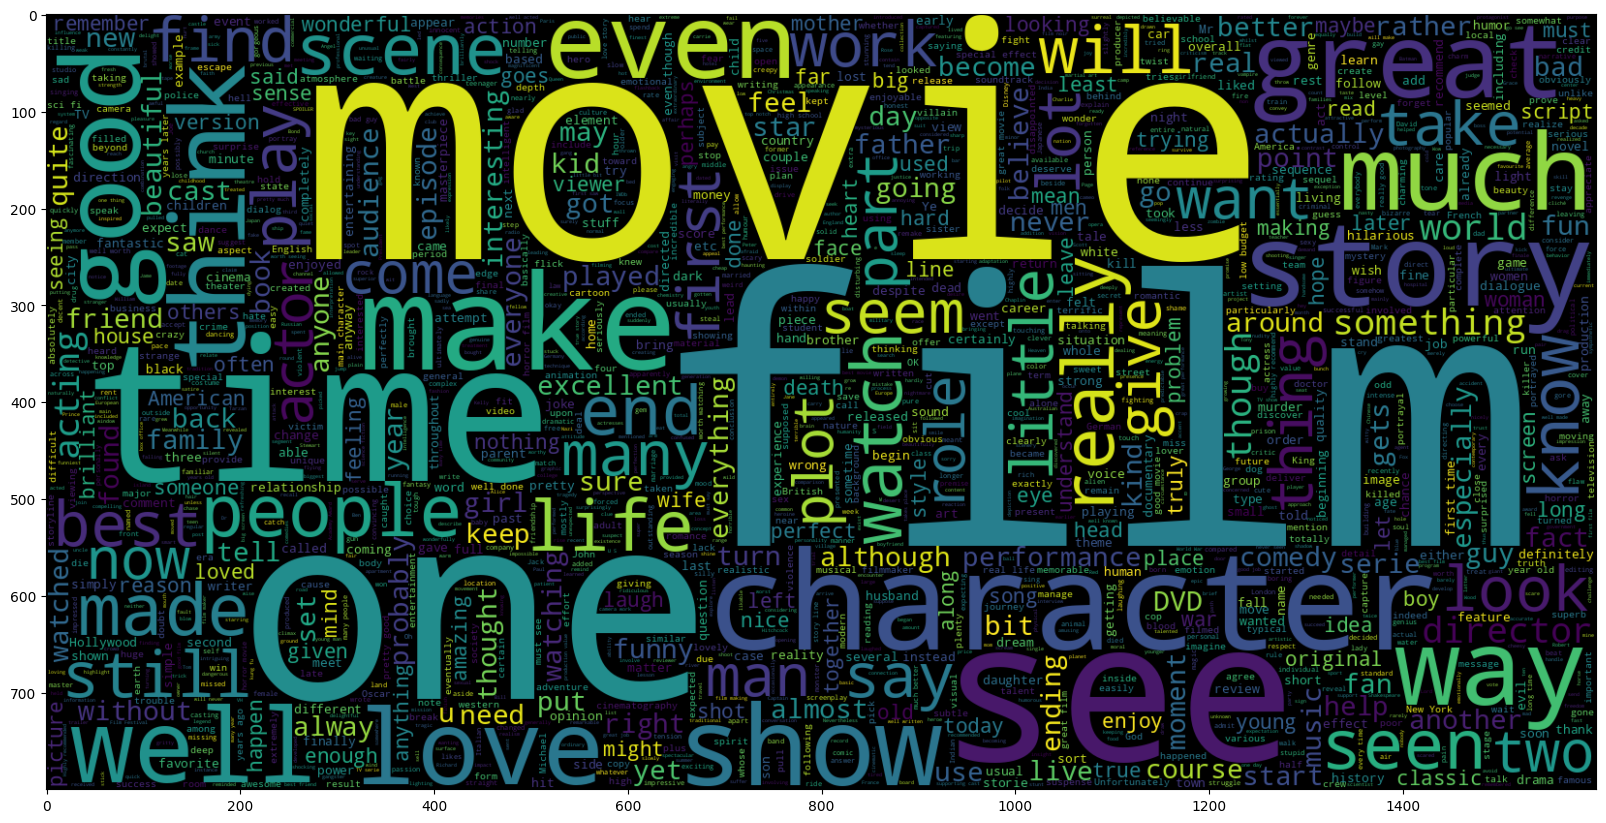

In [11]:
def show_wordCloud(sentiment):
    plt.figure(figsize = (20,20))
    wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sentiment == sentiment].review))
    plt.imshow(wc , interpolation = 'bilinear')
    
show_wordCloud(1)

### Negative Reviews

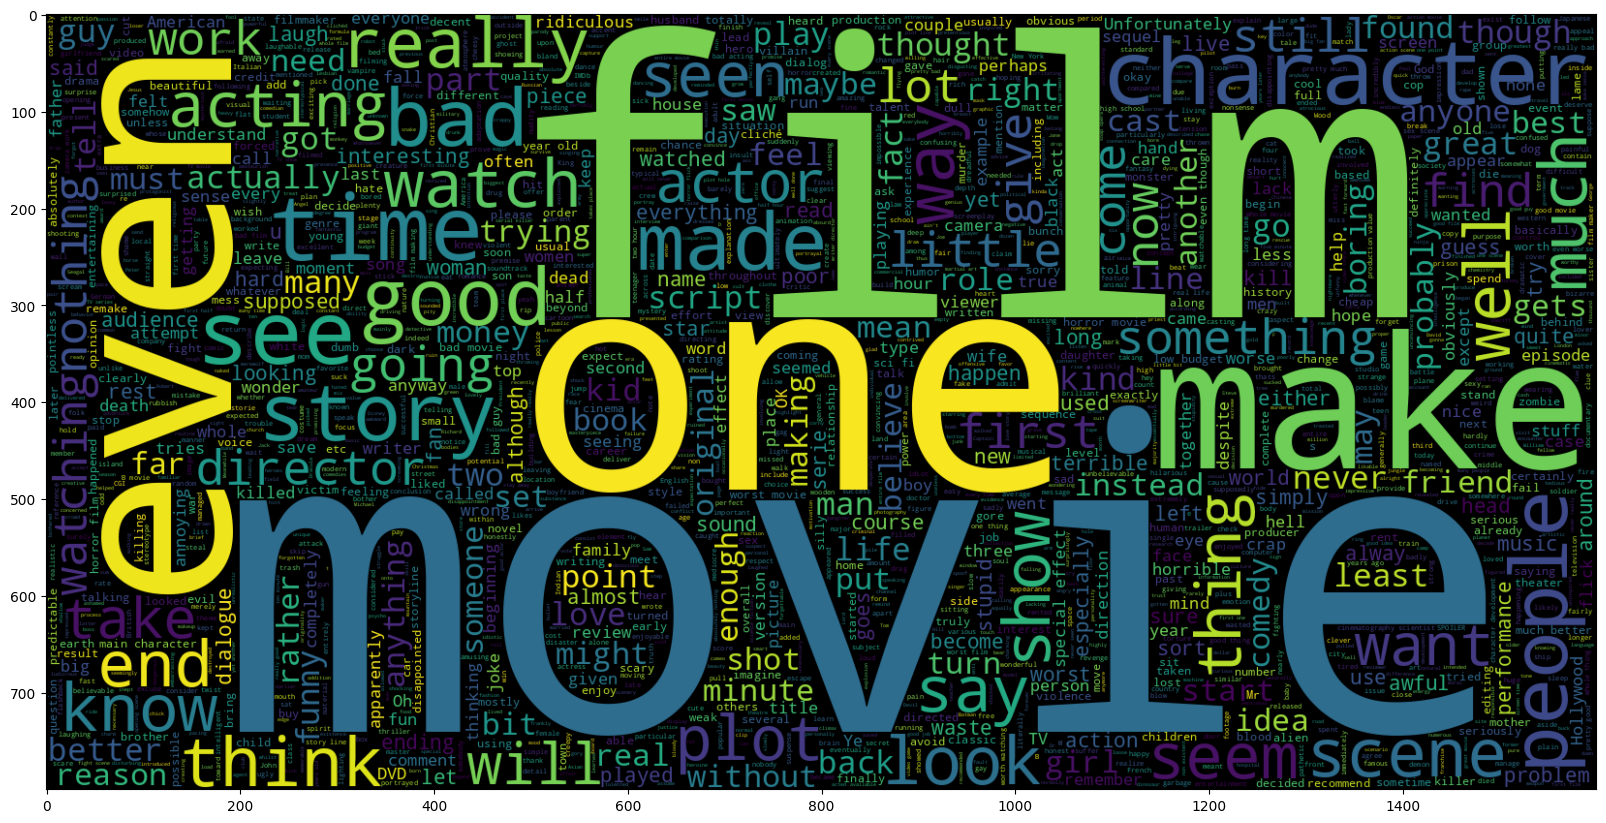

In [12]:
show_wordCloud(0)

### Character Count per Review

This helps me understand whether there's a noticeable difference in review length between sentiments, which could influence model performance.

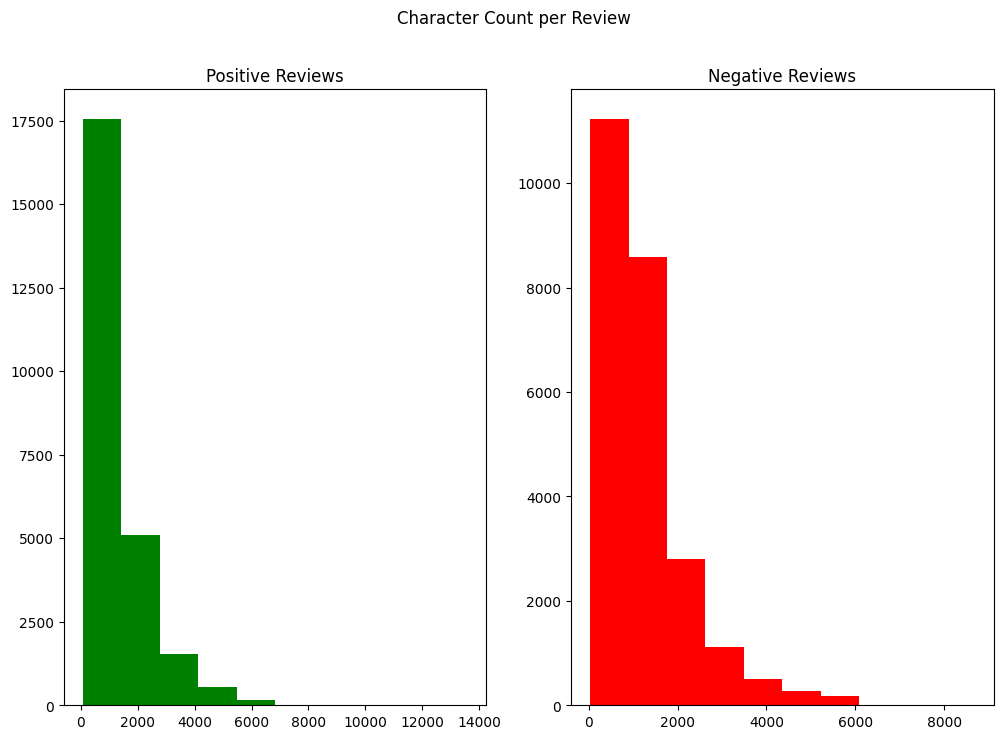

In [13]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
text_len = data[data['sentiment'] == 1]['review'].str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
text_len = data[data['sentiment'] == 0]['review'].str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
fig.suptitle('Character Count per Review')
plt.show()

### Word Count per Review

By comparing these distributions, I can check whether there's a pattern in review length that correlates with sentiment.

> **Note:** When fine-tuning the RoBERTa model, I set a maximum token length of **256**.  
> This plot helps me estimate how much of the dataset might get truncated due to this token limit, allowing me to understand potential information loss during training.


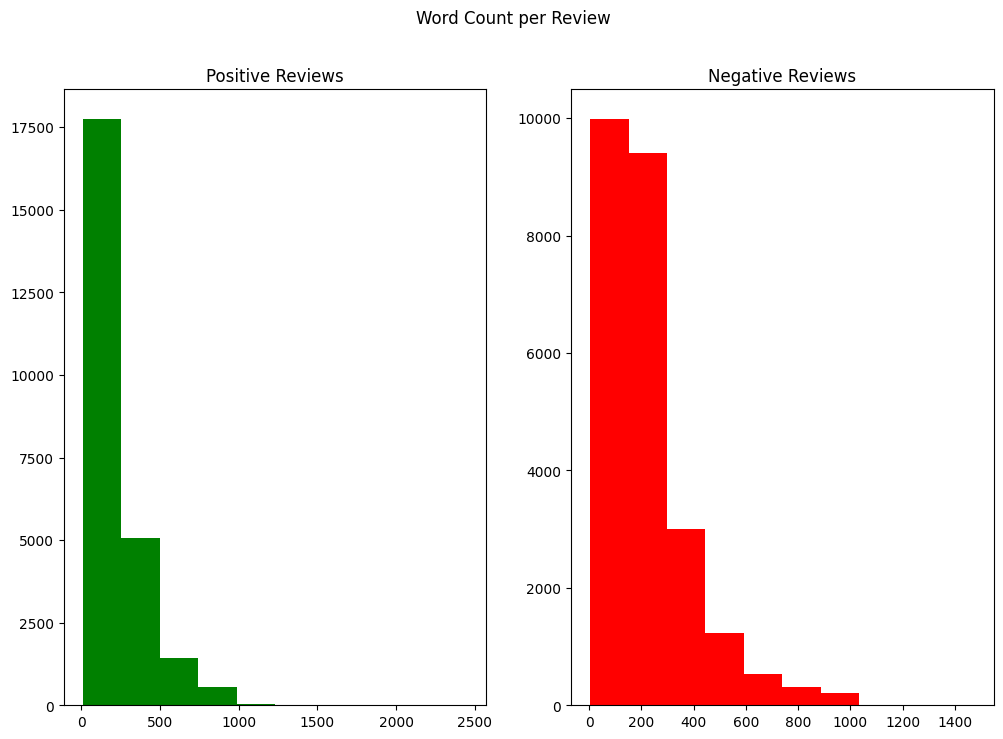

In [14]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
text_len = data[data['sentiment'] == 1]['review'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
text_len = data[data['sentiment'] == 0]['review'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
fig.suptitle('Word Count per Review')
plt.show()

### Average Word Count per Review

This gives me insight into whether there's any difference in word usage complexity or style between the two sentiment classes.


Text(0.5, 0.98, 'Average Word Count per Review')

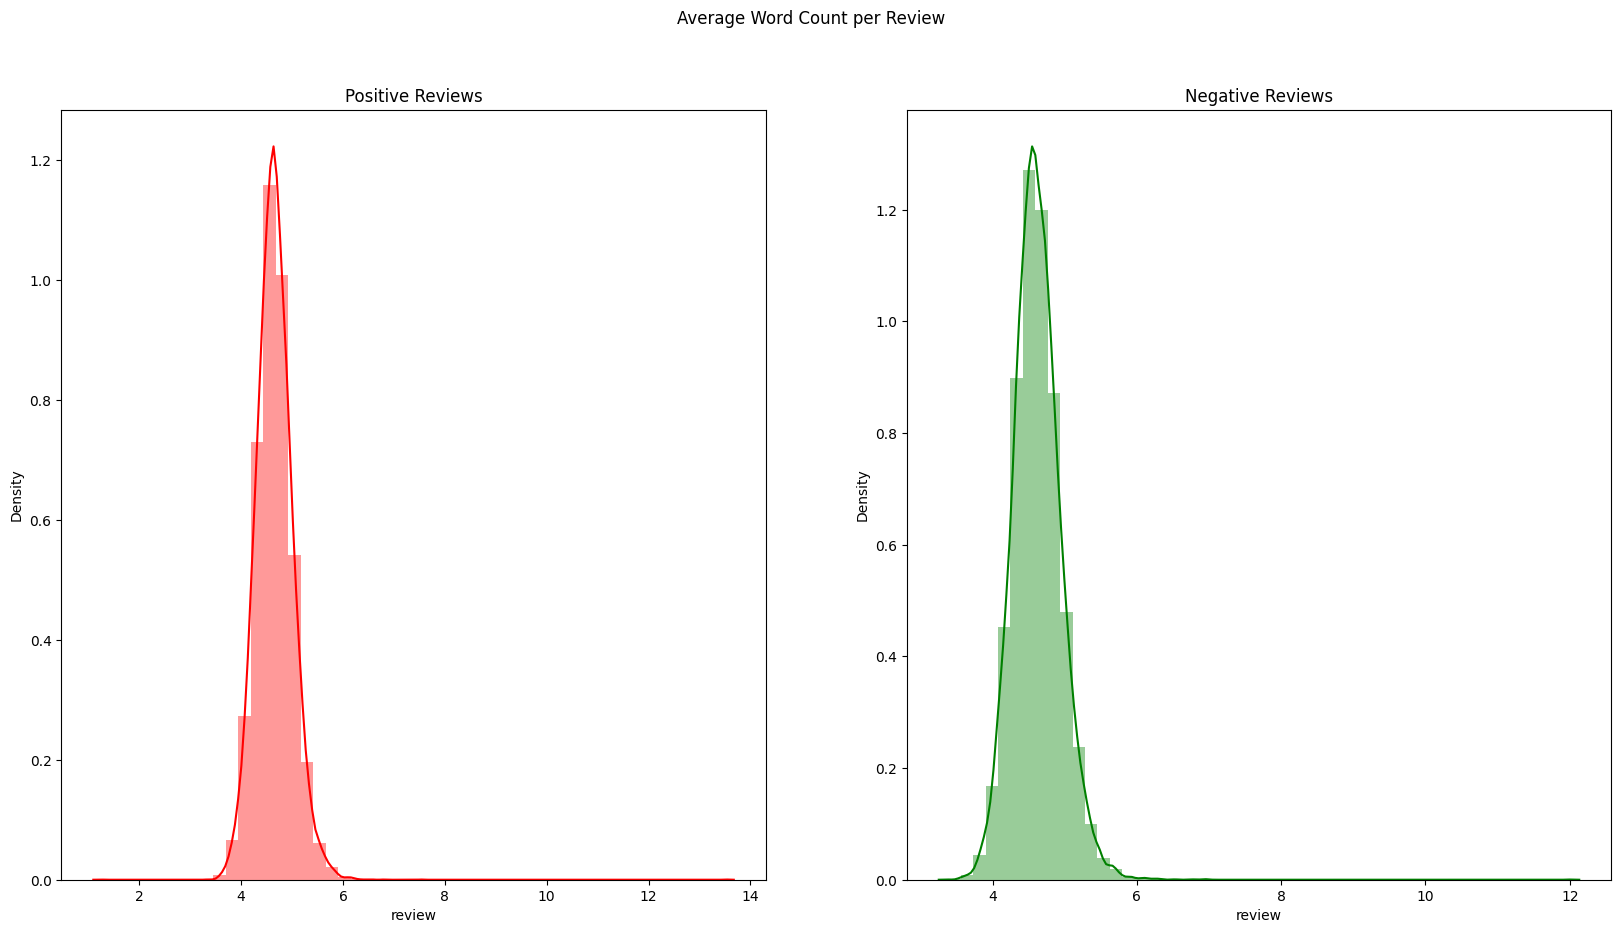

In [15]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
word = data[data['sentiment'] == 1]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Positive Reviews')
word = data[data['sentiment'] == 0]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Negative Reviews')
fig.suptitle('Average Word Count per Review')

In [16]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.review)
corpus[:5]

['One', 'of', 'the', 'other', 'reviewers']

### Most Common Words in the Corpus

Here, I use Python’s `Counter` to identify the top 10 most frequent words in the entire corpus.  
This helps me get a sense of the most dominant terms across all reviews, regardless of sentiment.


In [17]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'the': 564497,
 'a': 304820,
 'and': 299772,
 'of': 281598,
 'to': 259896,
 'is': 201675,
 'in': 168740,
 'I': 132228,
 'that': 125878,
 'this': 112824}

In [18]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

## Most Frequent N-grams in Reviews

I extract and visualize the top 1-gram and 2-gram words in the reviews using a bar plot.  
This gives me a better understanding of commonly co-occurring word patterns across the dataset.


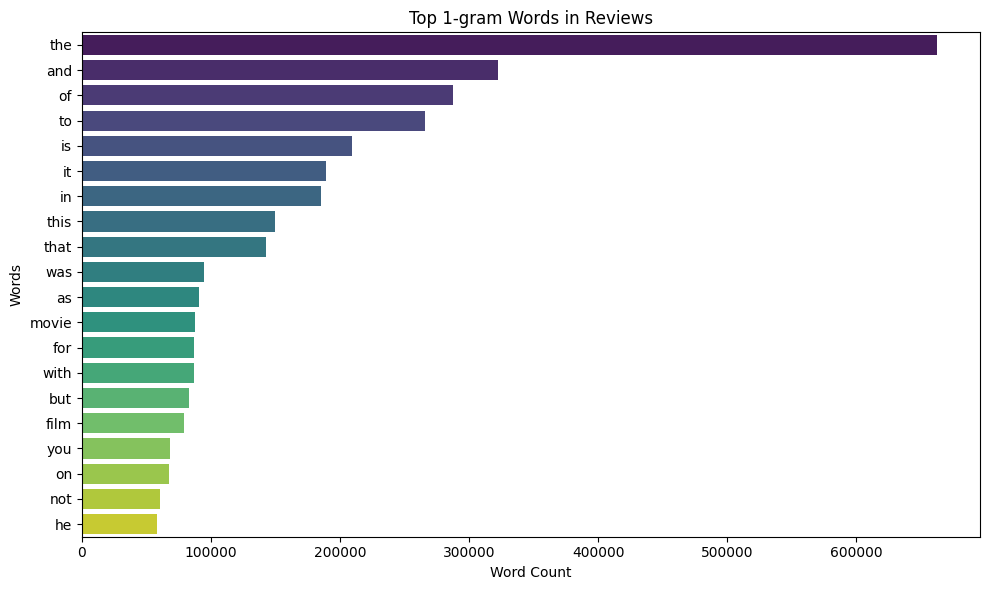

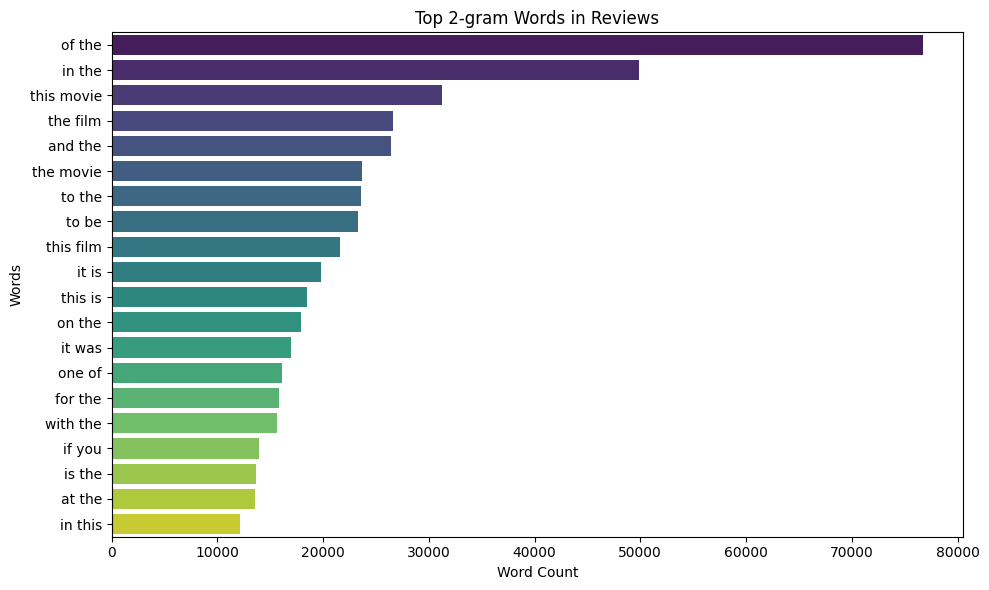

In [19]:
for g in range(1, 3):
    most_common = get_top_text_ngrams(data["review"], 20, g)
    temp_df = pd.DataFrame(most_common, columns=["Common_Words", "Word_Count"])

    plt.figure(figsize=(10, 6))
    sns.barplot(data=temp_df, x="Word_Count", y="Common_Words", palette="viridis")
    plt.title(f"Top {g}-gram Words in Reviews")
    plt.xlabel("Word Count")
    plt.ylabel("Words")
    plt.tight_layout()
    plt.show()

### Save the Cleaned Dataset

This file will be used later during the model training phase.

Training Phase: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1KtyW1fZvUO8Q4yD7JHfyiLkd_tBQSKpB)


In [30]:
data.to_csv('cleaned-imdb-dataset.csv', index=False)